<style>
@font-face {
  font-family: 'IRANSans';
  src: url('fonts/IRANSansXFaNum-Regular.ttf') format('woff');
}
.custom-font {
  font-family: 'IRANSans';
  direction: rtl;
}
</style>

Prediction

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import xgboost as xgb  
import matplotlib.font_manager as fm
import arabic_reshaper
import warnings
warnings.filterwarnings('ignore')




In [13]:
df = pd.read_csv(r'C:\Users\Taha\Desktop\Folder\QBTC-Divar-Project\Datas\Divar.csv')

Preprocessing

In [14]:
       
df_filtered = df[df['price_value'].notna()].copy()
print(f"Number of Records for sell {len(df_filtered):,}")
        
Q1 = df_filtered['price_value'].quantile(0.01)
Q3 = df_filtered['price_value'].quantile(0.99)
df_filtered = df_filtered[(df_filtered['price_value'] >= Q1) & (df_filtered['price_value'] <= Q3)]
print(f"After remove Outliers : {len(df_filtered):,}")

Number of Records for sell 568,346
After remove Outliers : 557,001


Feature Eng

In [15]:
df_features = df_filtered.copy()

def convert_persian_year_to_numeric(year_str):
        if pd.isna(year_str):
            return np.nan
        try:
            persian_to_english = {'۰': '0', '۱': '1', '۲': '2', '۳': '3', '۴': '4',
                                '۵': '5', '۶': '6', '۷': '7', '۸': '8', '۹': '9'}
            english_year = str(year_str)
            for p, e in persian_to_english.items():
                english_year = english_year.replace(p, e)
            return int(english_year)
        except:
            return np.nan


if 'construction_year' in df_features.columns:
    df_features['construction_year_numeric'] = df_features['construction_year'].apply(
        convert_persian_year_to_numeric
    )
    current_year = 1404 
    df_features['building_age'] = current_year - df_features['construction_year_numeric']
    df_features['building_age'] = df_features['building_age'].clip(0, 100)
        
if 'rooms_count' in df_features.columns:
    room_mapping = {
        'بدون اتاق': 0, 'یک': 1, 'دو': 2, 'سه': 3, 
        'چهار': 4, 'پنج': 5, 'شش': 6
    }
    df_features['rooms_numeric'] = df_features['rooms_count'].map(room_mapping)
        
if 'floor' in df_features.columns:
    df_features['floor_numeric'] = pd.to_numeric(df_features['floor'], errors='coerce')
        
if 'total_floors_count' in df_features.columns:
    df_features['total_floors_numeric'] = pd.to_numeric(df_features['total_floors_count'], errors='coerce')
        
if 'unit_per_floor' in df_features.columns:
    df_features['unit_per_floor_numeric'] = pd.to_numeric(df_features['unit_per_floor'], errors='coerce')
        
if 'building_size' in df_features.columns:
    df_features['price_per_sqm'] = df_features['price_value'] / df_features['building_size']
    df_features['price_per_sqm'] = df_features['price_per_sqm'].replace([np.inf, -np.inf], np.nan)
        
if all(col in df_features.columns for col in ['building_size', 'land_size']):
    df_features['building_to_land_ratio'] = df_features['building_size'] / df_features['land_size']
    df_features['building_to_land_ratio'] = df_features['building_to_land_ratio'].replace([np.inf, -np.inf], np.nan)
        
amenity_cols = ['has_balcony', 'has_elevator', 'has_warehouse', 'has_parking']
for col in amenity_cols:
    if col in df_features.columns:
        df_features[col] = df_features[col].map({'true': 1, True: 1, 'false': 0, False: 0})
        
if all(col in df_features.columns for col in amenity_cols):
    df_features['amenity_score'] = df_features[amenity_cols].sum(axis=1)

Features Engineering

In [16]:
numeric_features = [
    'building_size', 'land_size', 'location_latitude', 'location_longitude',
    'building_age', 'rooms_numeric', 'floor_numeric', 'total_floors_numeric',
    'unit_per_floor_numeric', 'amenity_score', 'building_to_land_ratio'
]
        
categorical_features = [
    'cat2_slug', 'cat3_slug', 'city_slug', 'neighborhood_slug',
    'deed_type', 'building_direction', 'floor_material',
    'has_warm_water_provider', 'has_heating_system', 'has_cooling_system'
]
        
available_numeric = [col for col in numeric_features if col in df.columns]
available_categorical = [col for col in categorical_features if col in df.columns]
        
print(f"Numerical {len(available_numeric)}")
print(f"Categorical: {len(available_categorical)}")

Numerical 4
Categorical: 10


Preparing Features

In [17]:
df_model = df_features.copy()
label_encoders = {}

numeric_imputer = SimpleImputer(strategy='median')
for col in numeric_features:
    if col in df_model.columns:
        df_model[col] = numeric_imputer.fit_transform(df_model[[col]]).flatten()
        
categorical_imputer = SimpleImputer(strategy='most_frequent')
for col in categorical_features:
    if col in df_model.columns:
        df_model[col] = categorical_imputer.fit_transform(df_model[[col]]).flatten()

for col in categorical_features:
    if col in df_model.columns:
        le = LabelEncoder()
        df_model[col + '_encoded'] = le.fit_transform(df_model[col].astype(str))
        label_encoders[col] = le
        
final_features = numeric_features + [col + '_encoded' for col in categorical_features if col in df_model.columns]
final_features = [col for col in final_features if col in df_model.columns]
        
X = df_model[final_features]
y = df_model['price_value']
        
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]
        
print(f"Final Shape: {X.shape}")
print(f"Features Num: {len(final_features)}")

Final Shape: (557001, 21)
Features Num: 21


Train Models

In [18]:
scaler = StandardScaler()
models = {}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
        
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1000),
    'Lasso Regression': Lasso(alpha=1000),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(  
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0 
    )
}
        
results = {}
        
for name, model in models.items():
    print(f" Train {name}...")
            
    if 'Regression' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
            
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
            
    results[name] = {
        'model': model,
        'mae': mae,
        'rmse': rmse,
        'mse': mse,
        'r2': r2,
        'y_pred': y_pred,
        'y_test': y_test
    }

    print(f"{name}: R² = {r2:.3f}, MAE = {mae:,.0f}, RMSE = {rmse:,.0f}, MSE = {mse:,.0f}")

models = results    
        

 Train Linear Regression...
Linear Regression: R² = 0.204, MAE = 3,893,636,269, RMSE = 7,297,929,355, MSE = 53,259,772,870,673,391,616
 Train Ridge Regression...
Ridge Regression: R² = 0.204, MAE = 3,892,119,696, RMSE = 7,297,910,634, MSE = 53,259,499,626,522,353,664
 Train Lasso Regression...
Lasso Regression: R² = 0.204, MAE = 3,893,635,656, RMSE = 7,297,929,344, MSE = 53,259,772,712,723,914,752
 Train Random Forest...
Random Forest: R² = 0.619, MAE = 2,109,980,930, RMSE = 5,047,179,971, MSE = 25,474,025,657,331,728,384
 Train Gradient Boosting...
Gradient Boosting: R² = 0.489, MAE = 2,777,960,730, RMSE = 5,848,251,697, MSE = 34,202,047,917,171,957,760
 Train XGBoost...
XGBoost: R² = 0.572, MAE = 2,441,967,785, RMSE = 5,348,794,609, MSE = 28,609,603,768,290,086,912


Model Validations

In [31]:
comparison_df = pd.DataFrame({
    'model': list(models.keys()),
    'R² Score': [models[name]['r2'] for name in models.keys()],
    'MAE (Million Tooman)': [models[name]['mae']/1000000 for name in models.keys()],
    'RMSE (Million Tooman)': [models[name]['rmse']/1000000 for name in models.keys()],
    'MSE (Million Tooman)': [models[name]['mse']/1000000 for name in models.keys()]
})

comparison_df = comparison_df.sort_values('R² Score', ascending=False)
print(comparison_df.to_string(index=False, float_format='%.3f'))
# Best Model
best_model_name = comparison_df.iloc[0]['model']
print(f"\nBest Model: {best_model_name}")

            model  R² Score  MAE (Million Tooman)  RMSE (Million Tooman)  MSE (Million Tooman)
    Random Forest     0.619              2109.981               5047.180    25474025657331.727
          XGBoost     0.572              2441.968               5348.795    28609603768290.086
Gradient Boosting     0.489              2777.961               5848.252    34202047917171.957
 Ridge Regression     0.204              3892.120               7297.911    53259499626522.352
 Lasso Regression     0.204              3893.636               7297.929    53259772712723.914
Linear Regression     0.204              3893.636               7297.929    53259772870673.391

Best Model: Random Forest


Results

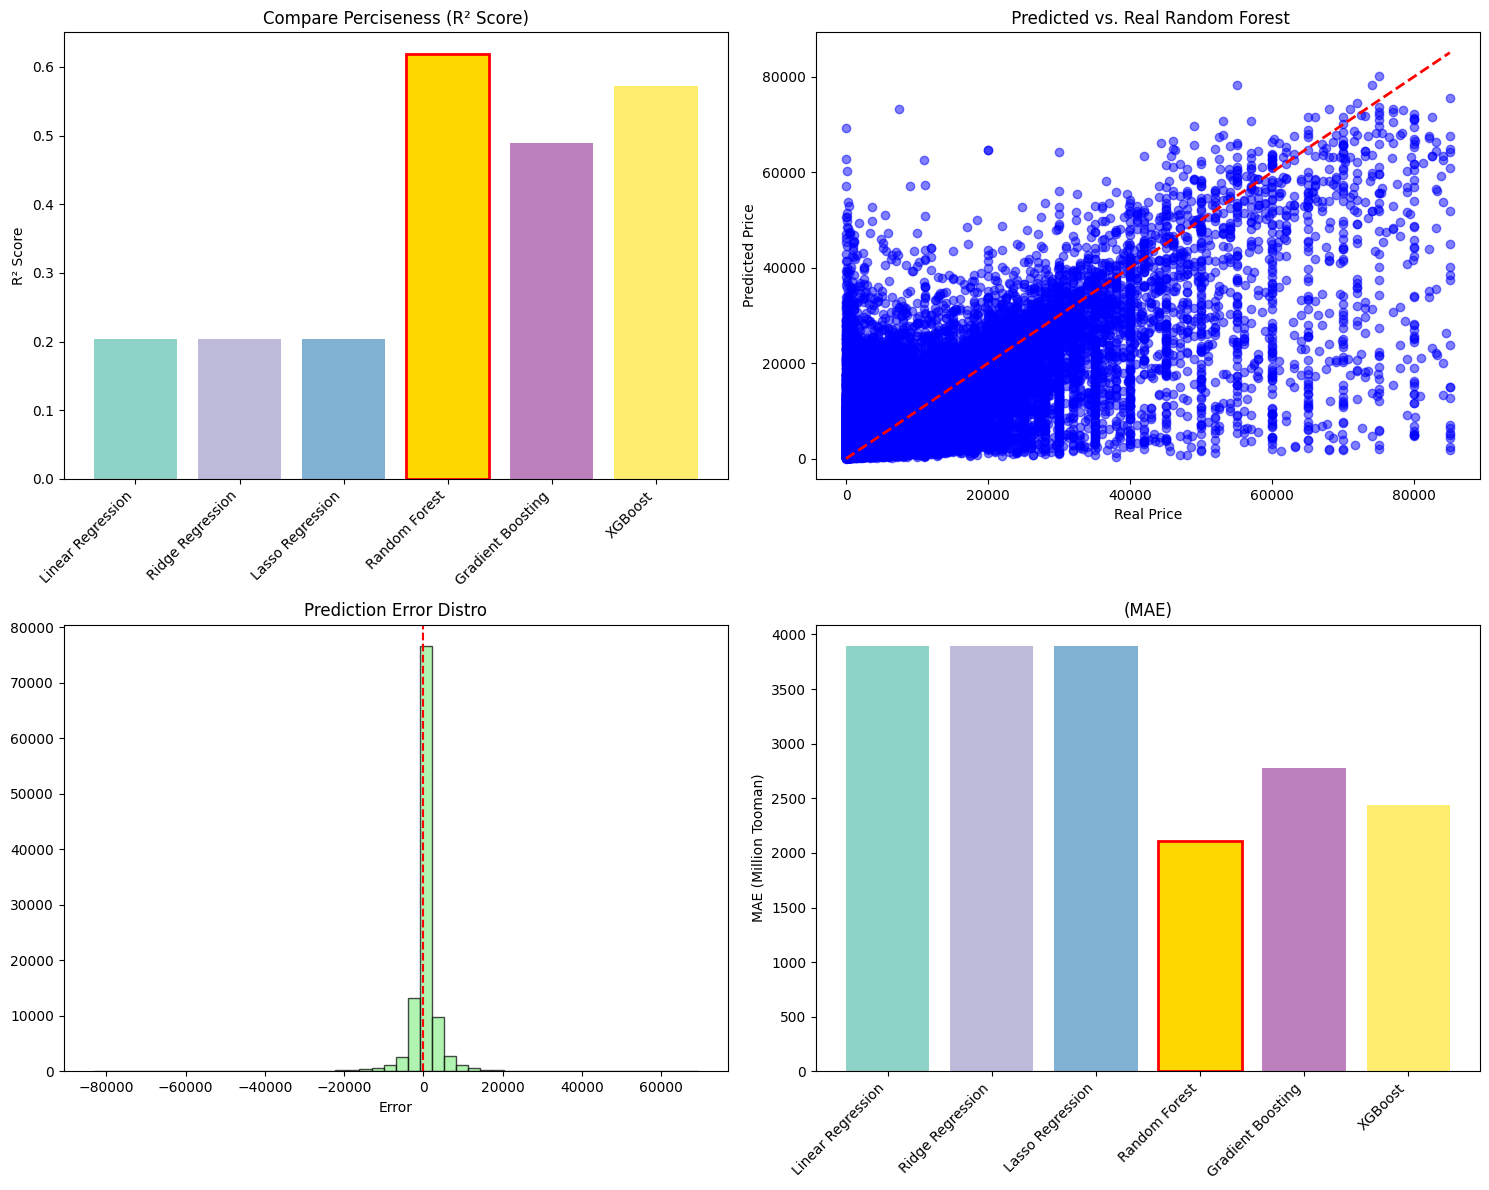

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
model_names = list(models.keys())
r2_scores = [models[name]['r2'] for name in model_names]
        
colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))
bars = axes[0,0].bar(range(len(model_names)), r2_scores, color=colors)
axes[0,0].set_xticks(range(len(model_names)))
axes[0,0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0,0].set_title(("Compare Perciseness (R² Score)"))
axes[0,0].set_ylabel('R² Score')
        
best_idx = model_names.index(best_model_name)
bars[best_idx].set_color('gold')
bars[best_idx].set_edgecolor('red')
bars[best_idx].set_linewidth(2)
        
best_model = models[best_model_name]
y_test = best_model['y_test']
y_pred = best_model['y_pred']
        
axes[0,1].scatter(y_test/1000000, y_pred/1000000, alpha=0.5, color='blue')
min_val = min(y_test.min(), y_pred.min())/1000000
max_val = max(y_test.max(), y_pred.max())/1000000
axes[0,1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[0,1].set_xlabel(("Real Price"))
axes[0,1].set_ylabel("Predicted Price")
axes[0,1].set_title((f' Predicted vs. Real {best_model_name}'))
        
errors = (y_pred - y_test) / 1000000
axes[1,0].hist(errors, bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1,0].set_xlabel(("Error"))
axes[1,0].set_ylabel((""))
axes[1,0].set_title(("Prediction Error Distro"))
axes[1,0].axvline(0, color='red', linestyle='--')
        
mae_scores = [models[name]['mae']/1000000 for name in model_names]
bars_mae = axes[1,1].bar(range(len(model_names)), mae_scores, color=colors)
axes[1,1].set_xticks(range(len(model_names)))
axes[1,1].set_xticklabels(model_names, rotation=45, ha='right')
axes[1,1].set_title(("(MAE)"))
axes[1,1].set_ylabel("MAE (Million Tooman)")
        
best_mae_idx = np.argmin(mae_scores)
bars_mae[best_mae_idx].set_color('gold')
bars_mae[best_mae_idx].set_edgecolor('red')
bars_mae[best_mae_idx].set_linewidth(2)
        
plt.tight_layout()
plt.show()

Importance of the Features


Feature ImportanceRandom Forest:
--------------------------------------------------
                   Feature  Importance
             building_size      0.2357
         city_slug_encoded      0.2086
             rooms_numeric      0.1028
         location_latitude      0.0973
        location_longitude      0.0837
 neighborhood_slug_encoded      0.0714
              building_age      0.0466
         cat3_slug_encoded      0.0325
                 land_size      0.0236
             amenity_score      0.0209
    building_to_land_ratio      0.0204
             floor_numeric      0.0135
         cat2_slug_encoded      0.0075
has_heating_system_encoded      0.0061
    floor_material_encoded      0.0054


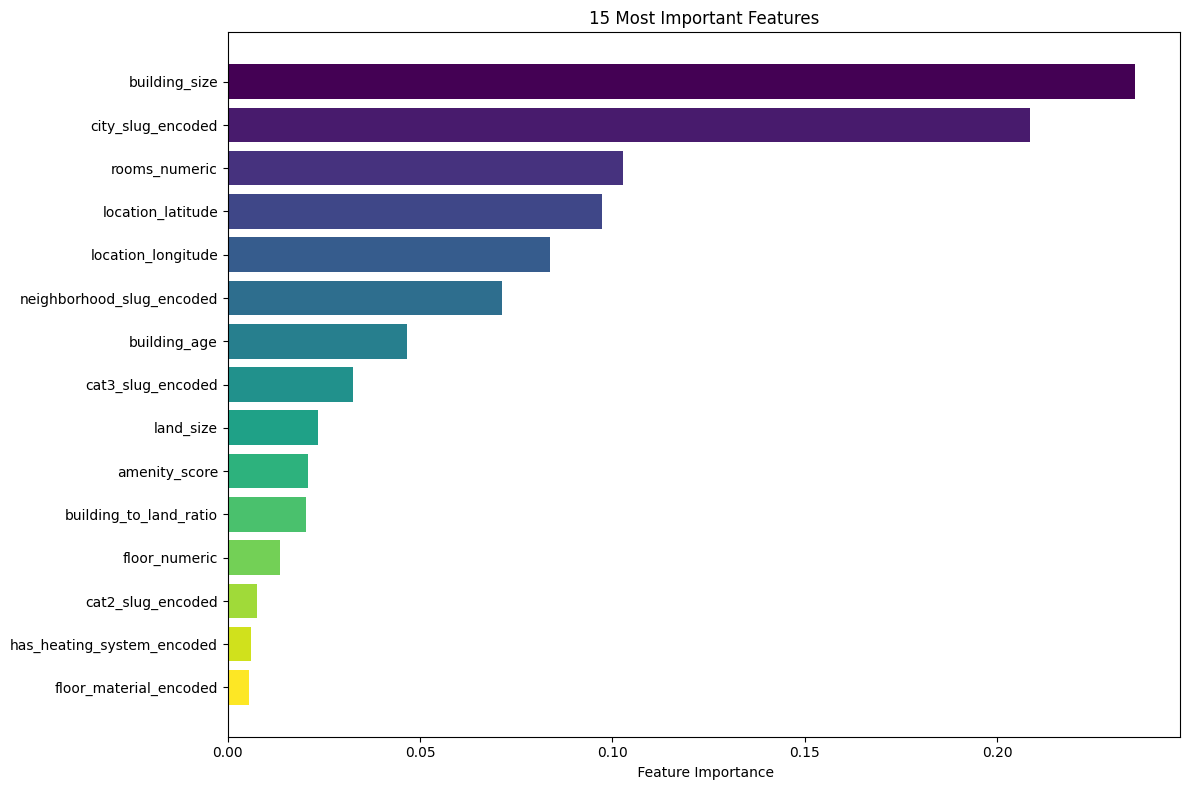

In [30]:
# 
model = models[best_model_name]['model']
            
importance_df = pd.DataFrame({
    'Feature': final_features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)
            
print(f"\nFeature Importance{best_model_name}:")
print("-" * 50)
print(importance_df.head(15).to_string(index=False, float_format='%.4f'))
            
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
plt.barh(range(len(top_features)), top_features['Importance'], color=colors)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel((" Feature Importance"))
plt.title(("15 Most Important Features"))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()